# Optimització - Linear regression

En estadística, la **regressió lineal** és un enfocament lineal per modelar la relació entre una resposta escalar (o variable dependent) i una o més variables explicatives (o variables independents).

En regressió lineal, les relacions es modelen mitjançant funcions lineals on els paràmetres del model s’estimen a partir de les dades. 
Aquests models s'anomenen models lineals. 

Suposem que treballem amb un conjunt de dades $ \{y_{i}, x_{i_1}, \ldots, x_{i_m} \}_{i = 1}^{n}$ de $n$ unitats. 

Un **model de regressió lineal** assumeix que la relació entre la variable dependent $y$ i el vector $p$ dels regressors $x$ és lineal. 
Així, el model pren la forma:
$${\displaystyle y_{i}=\beta _{0}+\beta _{1}x_{i_1}+\cdots +\beta _{p}x_{i_p},\qquad i=1,\ldots ,n,}$$

In [1]:
# Comprovem que autograd estigui instal·lat
if __name__ == '__main__':
    try:
        import autograd
    except:
        print('No s\'ha detectat autograd instal·lat')
        if input('Vols instalar autograd? [s/n]').strip().lower() == 's':
            !pip3 install --user -U autograd
            !pip install --user -U autograd
        else:
            print('Abans de continuar instal·la autograd')

In [2]:
from plot_utils import *

import autograd.numpy as np
from autograd import elementwise_grad as grad, value_and_grad
import matplotlib.pyplot as plt
import pandas as pd
import random

if __name__ == '__main__':
    from IPython.display import display
    
    %matplotlib inline

No es permet l'ús de cap llibreria o funció que no estigui ja importat, sigui aquí o més abaix en el notebook.

Per Kaggle es permet l'ús d'altres llibreries/funcions sempre i quan únicament es facin servir pel processament de dades, i no pel model i/o predicció.

# AutoGrad

En la part anterior, donada una funció havíem de definir també la funció que retorna el seu gradient.

En aquesta pràctica, però, veurem que mitjançant l'ús de la llibreria **AutoGrad**, això no és necessari.

Consideren les següents funcions:

In [3]:
def f1(x):
    return x**2

def f2(x):
    x, y = x[0], x[1]
    return x**2 + y**2

def f3(x):
    x, y, z = x[0], x[1], x[2]
    return (100 * (y - x**2)**2 + (1 - x)**2) + (100 * (z - y**2)**2 + (1 - y)**2)

Donada la funció `f1`, podem fàcilment derivar el seu gradient, que és $2x$.

Definim-lo manualment:

In [4]:
def grad_f1_manual(x):
    return 2*x

Ara, obtinguem la funció gradient a partir d'autograd:

In [5]:
grad_f1 = grad(f1)

Podem comprovar que **les dues donen el mateix valor de gradient evaluat en un punt $x$**.

In [6]:
x0 = np.asarray([1023.0])
print('Calcul manual gradient: df1\'(x0) = {}'.format(grad_f1_manual(x0)[0]))
print('Autograd: df1\'(x0) = {}'.format(grad_f1(x0)[0]))

assert np.allclose(grad_f1_manual(x0), grad_f1(x0)) 

Calcul manual gradient: df1'(x0) = 2046.0
Autograd: df1'(x0) = 2046.0


També podem utilitzar `value_and_grad` per obtenir directament amb la **imatge de la funció i el seu gradient en un punt $x$**:

In [7]:
val_grad_f1 = value_and_grad(f1)
print(val_grad_f1(x0))

value, gradient = val_grad_f1(x0)
assert np.allclose(value, f1(x0))
assert np.allclose(gradient, grad_f1(x0))

(array([1046529.]), array([2046.]))


Inclús podem aplicar `grad` sobre un altre `grad` per obtenir la 2a derivada (o Hessià en multiples dimensions).

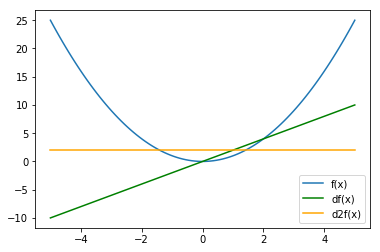

In [8]:
grad_f1 = grad(f1) # df(x) = 2 * x
grad2_f1 = grad(grad_f1) # d2f(x) = 2

if __name__ == '__main__':
    x = np.linspace(-5, 5, 100)
    plt.plot(x, f1(x), label = 'f(x)')
    plt.plot(x, grad_f1(x), color='green', label = 'df(x)')
    plt.plot(x, grad2_f1(x), color='orange', label = 'd2f(x)')
    plt.legend()

# Descens del gradient

**El primer pas serà implementar la mateixa funció `gradient_descend` que havieu fet en la part anterior, però ara mitjançant l'ús de la llibreria `autograd` i fent-la multidimensional.**

Aquesta funció hauria d'executar sense problemes, i donar el mínim, per les tres funcions `f1`, `f2` i `f3` definides més adalt, de 1, 2 i 3 dimensions respectivament. Però, també haurà de funcionar per les següents parts de la pràctica, amb 100 o més dimensions.

In [9]:
# Per utilitzar aquesta llibreria cal tenir instalar el paquet tqdm
from tqdm import tqdm_notebook

def human_format(num):
    """
    Funció auxiliar per formatar els nombres

    100    -> 100.00
    2100   -> 2.10K
    342100 -> 342.10K
    etc.    
    
    :param num: Nombre a formatar
    :return: String amb el nombre formatat
    """
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '%.2f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

def gradient_descend(f, x0, alpha, eps=1e-6, max_iter=1000, print_iters=1000):
    """
    Aquesta funció implementa l'algorisme de descens pel gradient, és a dir,
    donat un punt inicial, la funció de la que calculem el gradient i el pas, 
    intenta trobar el mínim de la funció seguint el gradient en direcció oposada.
    
    Pel criteri d'aturada, considerarem si ||x^{k+1} - x^k|| < eps, és a dir
    si la norma de la diferència és més petita que eps.
    
    Cada print_iters cal mostrar el resultat actual en la següent forma:
        "{}/{:.2f}".format(human_format(itr), float(valor_de_f_en_x))
    És dir, un missatge que inclogui la iteració i el valor de f en el punt
    
    :param f: Funció a minimitzar
    :param x0: Punt inicial
    :param alpha: Pas de cada iteració
    :param eps: Moviment mínim realitzat abans de parar
    :param max_epochs: Iteracions màximes a realitzar
    :param print_iters: Numero d'iteracions per printar resultats
    :return: La funció retornarà el punt on es troba el mínim
    """
    i = 0
    val_grad_f = value_and_grad(f)
    while i < max_iter:
        grad = val_grad_f(x0)
        if np.linalg.norm(alpha * grad[1]) > eps:
            x0 = x0 - alpha * grad[1]
            i += 1

        else:
            break
        if (i%print_iters)==0:
            print("{}/{:.2f}".format(human_format(i), float(grad[0])))
    return x0

<div style='background: #FCD02C; color: #333; padding: 20px; border-radius: 5px;'>
    <div style='float: right; font-weight: bold;'>1.5/1.5</div>
    Perfecte
</div>

Busquem el mínim de cadascuna de les funcions:

In [10]:
if __name__ == '__main__':
    x0 = np.array([4.0])
    xm = gradient_descend(f1, x0, 0.01, 1e-6, 10000) # ~ @1s
    print(f'f1({xm}) = {f1(xm)}')

f1([4.98237376e-05]) = [2.48240483e-09]


In [11]:
if __name__ == '__main__':
    x0 = np.array([4.0, 5.1])
    xm = gradient_descend(f2, x0, 0.01, 1e-6, 10000) # ~ @1s
    print(f'f2({xm}) = {f2(xm)}')

f2([3.06804779e-05 3.91176093e-05]) = 2.4714790816465446e-09


In [12]:
if __name__ == '__main__':
    x0 = np.array([4.0, 5.1, 4.4]) # dividir grad/normadelgradient o alpha = 0.00001
    xm = gradient_descend(f3, x0, 0.0001, 1e-6, 50000) # ~ @30s
    print(f'f3({xm}) = {f3(xm)}')

1.00K/1.41
2.00K/1.38
3.00K/1.35
4.00K/1.31
5.00K/1.28
6.00K/1.25
7.00K/1.22
8.00K/1.19
9.00K/1.16
10.00K/1.13
11.00K/1.10
12.00K/1.07
13.00K/1.04
14.00K/1.01
15.00K/0.98
16.00K/0.95
17.00K/0.93
18.00K/0.90
19.00K/0.87
20.00K/0.85
21.00K/0.82
22.00K/0.80
23.00K/0.77
24.00K/0.75
25.00K/0.72
26.00K/0.70
27.00K/0.68
28.00K/0.65
29.00K/0.63
30.00K/0.61
31.00K/0.59
32.00K/0.57
33.00K/0.55
34.00K/0.53
35.00K/0.51
36.00K/0.49
37.00K/0.47
38.00K/0.45
39.00K/0.43
40.00K/0.42
41.00K/0.40
42.00K/0.38
43.00K/0.37
44.00K/0.35
45.00K/0.34
46.00K/0.32
47.00K/0.31
48.00K/0.29
49.00K/0.28
50.00K/0.27
f3([1.21262636 1.47124292 2.1662293 ]) = 0.26762081745762245


# Linear regression

Cas simple: **Donat un conjunt de punts (X, Y) 2D, podem trobar la recta que minimitza la distància entre aquesta i tots els punts?**

Recordatori: 

Per tal de definir una recta necesitem dos punts $(x_0, y_0)$ i $(x_1, y_1)$. A partir d'aquests dos punts podem definir la recta com:

$$y={\frac {y_{1}-y_{0}}{x_{1}-x_{0}}} (x-x_{0}) +y_{0} = m \cdot x + n$$

,X,Y
0,6.2,29
1,9.5,44
2,10.5,36
3,7.7,37
4,8.6,53


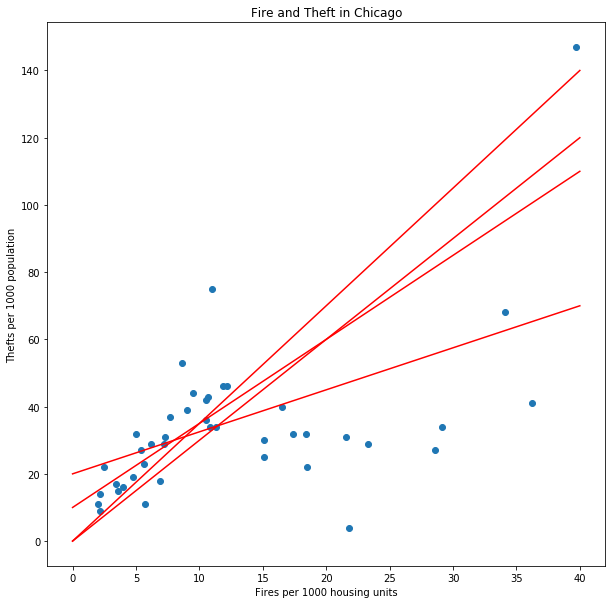

In [13]:
if __name__ == '__main__':
    # Lectura de les dades
    df = pd.read_csv('data/slr05.csv', index_col=0)
    display(df.head())

    # Visualització de les dades
    plt.figure(figsize = (10, 10))
    plt.scatter(df['X'], df['Y'])
    plt.xlabel('Fires per 1000 housing units')
    plt.ylabel('Thefts per 1000 population')
    plt.title('Fire and Theft in Chicago')

    # Possibles linies
    # Parametres plt.plot: (x0, x1), (y0, y1)
    plt.plot((0, 40), (0, 140), color='#ff0000')
    plt.plot((0, 40), (0, 120), color='#ff0000')
    plt.plot((0, 40), (10, 110), color='#ff0000')
    plt.plot((0, 40), (20, 70), color='#ff0000')

Per ara, donat que estem a 2D, podem visualitzar l'error, és a dir la distància respecte aquesta recta. Però tot i així és impossible que poguem visualitzar, d'entre les infinites línies possibles, la que s'ajusta millor a les dades.

**Necessitem un algorisme que la trobi automàticament,** però primer visualitzem l'error de cadascuna de les anteriors rectes:

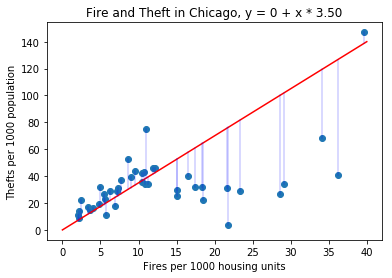

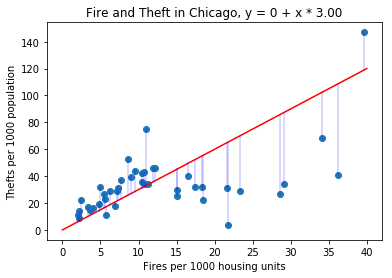

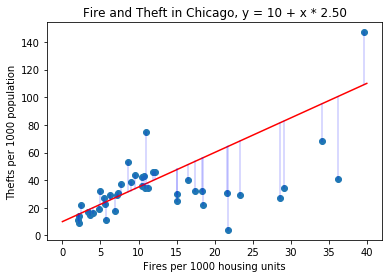

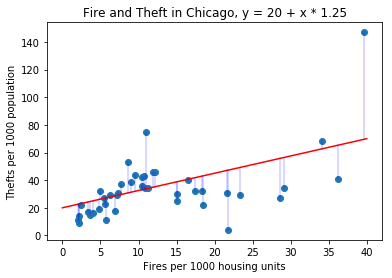

In [14]:
if __name__ == '__main__':
    for x1, y1, y0 in ((40, 140, 0), (40, 120, 0), (40, 110, 10), (40, 70, 20)):
        plt.figure()
        # Visualització de les dades
        plt.scatter(df['X'], df['Y'])
        plt.xlabel('Fires per 1000 housing units')
        plt.ylabel('Thefts per 1000 population')
        plt.title(f'Fire and Theft in Chicago, y = {y0} + x * {(y1 - y0) / x1:.2f}')

        # Visualització de la recta
        plt.plot((0, x1), (y0, y1), color='#ff0000')

        # Definció de la recta
        f = lambda x: (y1 - y0) / x1 * x + y0

        # Visualització de l'error per cada punt
        for _, (x, y) in df.iterrows():
            y_pred = f(x)
            plt.plot((x, x), (y, y_pred), color='b', alpha=0.2)

**Com definim un model que automàticament trobi aquesta recta?**

Primer de tot, assumim que nosaltres tenim unes dades de les quals dispossem els valors de $x$ i els corresponents valors de $y$. Per exemple, les dades anteriors.

1. Necessitem definir matemàticament una recta
$$ r: \hat{y} = m \cdot x + n $$
On $x$ és un punt que volem evaluar, $\hat{y}$ és la imatge obtinguda en el punt $x$, i $m$, $n$ són els paràmetres que defineixen la recta. Idealment, voldríem trobar aquelles $m$, $n$ que, per tot punt $x$ tinguéssim una $\hat{y}$ tal que $\hat{y}=y$.

2. Hem de mesurar l'error que estem cometent cada cop que provem una $m$, $n$ diferents (al que anomenarem *loss* del model). Per exemple, podríem definir l'error com a la distància entre el punt $y$ que hauria de ser i el $\hat{y}$ que ens dona el model:
$$\mathbb{L} = \sqrt{(y - \hat{y})^2}$$

3. Ara el que volem fer és trobar els valors de $m$, $n$ tal que $\mathbb{L}=0$. Si parem atenció a la funció definida per $\mathbb{L}$, veurem que efectivament $0$ és el mínim d'aquesta. Per tant, tot el que hem de fer és minimitzar la funció definida per
$$\mathbb{L} = \sqrt{(y - (m \cdot x + n))^2}$$

Per simplificar una mica el problema, unirem les variables que volem optimitzar $m,n$ en una de sola: $w$. Per fer-ho, expandirem la fòrmula anterior a:
$$\tilde{x} = (1, x), w = (n, m)$$

$$\mathbb{L} = \sqrt{(y - \tilde{x} \cdot w)^2}$$

On $\tilde{x}$ és un vector format per un $1$ i a continuació el valor de $x$ original. De forma que $\tilde{x} \cdot w = (1, x) \cdot (n, m) = n + x\cdot m = m\cdot x + n$ (producte escalar).

In [15]:


def add_bias(X):
    """
    Funció que donada el vector x crea el vector x', afegint una columna d'1's al davant.
    Per exemple, si X és
        [
            [1, 2, 5, 1, 5, 7],
            [9, 4, 2, 4, 6, 1],
            ...
            [5, 3, 1, 4, 5, 7]
        ]
    El retorn de la funció serà la matriu
        [
            [1, 1, 2, 5, 1, 5, 7],
            [1, 9, 4, 2, 4, 6, 1],
            ...
            [1, 5, 3, 1, 4, 5, 7]
        ]
    
    *Sense bucles*
    
    :param X: Matriu on cada fila és una dada i cada columna una característica
    :return: Mateixa matriu amb una columna de 1s davant
    """
    
    X = np.insert(X, 0, 1, axis=1)
    return X

def linear_regression(x, w):
    """
    Donat un punt i els parameters del model prediu el valor, implementant el càlcul de
    la regressió lineal:
            y' = w0 * x0 + w1 * x1 + ... + xp * wp
            
    *Sense bucles*
    
    :param x: Matriu de dades i features, on la primera columna son 1s, té per shape [NDades, NFeatures]
    :param w: Matriu de paràmetres, té per shape [1, NFeatures]
    :return: Vector de tamany [NDades] amb la predicció y' per a cada punt
    """
    return np.sum(x * w, axis=1)

def loss(y_true, y_pred):
    """
    Funció que calcula la diferència entre la solució real i la predita mitjançant
    distància euclidea
        ||y_true - y_pred||
        
    :param y_true: Valor real de la Y
    :param y_pred: Valor predit y' per a cada corresponent y
    :return: Error de la predicció
    """
    return np.sqrt(np.sum(np.power(abs(y_true - y_pred),2)/len(y_true))) # MEJORA 8
    # return np.sqrt(np.sum(np.power(abs(y_true - y_pred),2))

def model(w, x, y):
    """
    Funció que genera el model que volem optimizar, calculant l'error d'una
    predicció amb els pàrametres i valors passats
    
    :param w: Paràmetres del model
    :param x: Dades del model
    :param y: Valors a predir
    :return: Error (loss) de les prediccions
    """
    
    return loss(y, linear_regression(x, w))

<div style='background: #FCD02C; color: #333; padding: 20px; border-radius: 5px;'>
    <div style='float: right; font-weight: bold;'>3/3</div>
    Perfecte
</div>

Generem les dades que utilitzarem per entrenar el model (*X_fire*) i les seves etiquetes (*Y_fire*).

In [16]:
if __name__ == '__main__':
    X_fire = df['X'].values[:, np.newaxis]
    X_fire = add_bias(X_fire)
    Y_fire = df['Y'].values

Per optimizar el model, necesitem initcialitzar els seus pesos amb valors random.

In [17]:
if __name__ == '__main__':
    # Parametres per defecte del model
    w0 = np.random.normal(size=(1, X_fire.shape[1]))

    # Optimització del model
    wf_fire = gradient_descend(lambda w: model(w, X_fire, Y_fire), w0, 0.001, max_iter=20000, print_iters=1000) # ~ @5s
    print(wf_fire)

1.00K/21.41
2.00K/21.34
3.00K/21.26
4.00K/21.19
5.00K/21.12
6.00K/21.05
7.00K/20.99
8.00K/20.92
9.00K/20.86
10.00K/20.80
11.00K/20.74
12.00K/20.68
13.00K/20.63
14.00K/20.57
15.00K/20.52
16.00K/20.47
17.00K/20.42
18.00K/20.37
19.00K/20.33
20.00K/20.28
[[5.17246601 1.90897835]]


Visualització de la recta obtinguda amb el model i els errors de les seves prediccions.

Mean error: 15.02


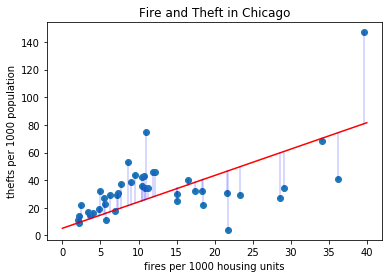

In [18]:
if __name__ == '__main__':
    plt.figure()
    # Visualització de les dades
    plt.scatter(df['X'], df['Y'])
    plt.xlabel('fires per 1000 housing units')
    plt.ylabel('thefts per 1000 population')
    plt.title('Fire and Theft in Chicago')

    # Visualització de la recta
    # Parametres plt.plot: (x0, x1), (y0, y1)
    plt.plot((0, 40), (wf_fire[0, 0], linear_regression((1, 40), wf_fire)), color='#ff0000')

    # Visualització de l'error a cada punt
    for _, (x, y) in df.iterrows():
        y_pred = linear_regression((1, x), wf_fire)
        plt.plot((x, x), (y, y_pred), color='b', alpha=0.2)

    y_fire_pred = linear_regression(X_fire, wf_fire)
    print('Mean error: {:.2f}'.format(np.mean(np.abs(Y_fire - y_fire_pred))))

# Dades multidimensionals sobre les dades

En l'apartat anterior tenim un sol valor de $x$ pel qual volíem obtenir un valor de $y$, però en la gran majoria de casos no serà així.

En aquest apartat volem trobar una regressió lineal tal que $dim(X) = 6$, i per tant necessitem un total de 7 paràmetres ($dim(w) = 7$)

In [19]:
if __name__ == '__main__':
    # Lectura de les dades
    dg = pd.read_csv('data/mlr10.csv', index_col=0)
    Y_pop = dg.values[:, 0]
    X_pop = dg.values[:, 1:]
    X_pop = add_bias(X_pop)
    display(dg.head())

,Total population (in thousands),% Change in population,% Change in children,% Free school lunch,% change in household income,Crime rate,% change in crime rate
0,6.9,1.8,30.2,58.3,27.3,84.9,-14.2
1,8.4,28.5,38.8,87.5,39.8,172.6,-34.1
2,5.7,7.8,31.7,83.5,26.0,154.2,-15.8
3,7.4,2.3,24.2,14.2,29.4,35.2,-13.9
4,8.5,-0.7,28.1,46.7,26.6,69.2,-13.9


In [20]:
if __name__ == '__main__':
    # Parametres per defecte del model
    w0 = np.random.normal(size=(1, X_pop.shape[1]))

    # Optimització del model
    wf_population = gradient_descend(lambda w: model(w, X_pop, Y_pop), w0, 0.001, max_iter=100000, print_iters=1000) # ~ @20s
    print(wf_population)

1.00K/12.90
2.00K/12.90
3.00K/12.90
4.00K/12.90
5.00K/12.90
6.00K/12.90
7.00K/12.90
8.00K/12.90
9.00K/12.90
10.00K/12.90
11.00K/12.90
12.00K/12.90
13.00K/12.90
14.00K/12.90
15.00K/12.90
16.00K/12.90
17.00K/12.90
18.00K/12.90
19.00K/12.90
20.00K/12.90
21.00K/12.90
22.00K/12.90
23.00K/12.90
24.00K/12.90
25.00K/12.90
26.00K/12.90
27.00K/12.90
28.00K/12.90
29.00K/12.90
30.00K/12.90
31.00K/12.90
32.00K/12.90
33.00K/12.90
34.00K/12.90
35.00K/12.90
36.00K/12.90
37.00K/12.90
38.00K/12.90
39.00K/12.90
40.00K/12.90
41.00K/12.90
42.00K/12.90
43.00K/12.90
44.00K/12.90
45.00K/12.90
46.00K/12.90
47.00K/12.90
48.00K/12.90
49.00K/12.90
50.00K/12.90
51.00K/12.90
52.00K/12.90
53.00K/12.90
54.00K/12.90
55.00K/12.90
56.00K/12.90
57.00K/12.90
58.00K/12.90
59.00K/12.90
60.00K/12.90
61.00K/12.90
62.00K/12.90
63.00K/12.90
64.00K/12.90
65.00K/12.90
66.00K/12.90
67.00K/12.90
68.00K/12.90
69.00K/12.90
70.00K/12.90
71.00K/12.90
72.00K/12.90
73.00K/12.90
74.00K/12.90
75.00K/12.90
76.00K/12.90
77.00K/12.90
78.00K/1

In [21]:
if __name__ == '__main__':
    # Utilitzant els paràmetres apresos, obtenim la predicció per a cada punt
    y_pop_pred = linear_regression(X_pop, wf_population)

Mean error: 9.83


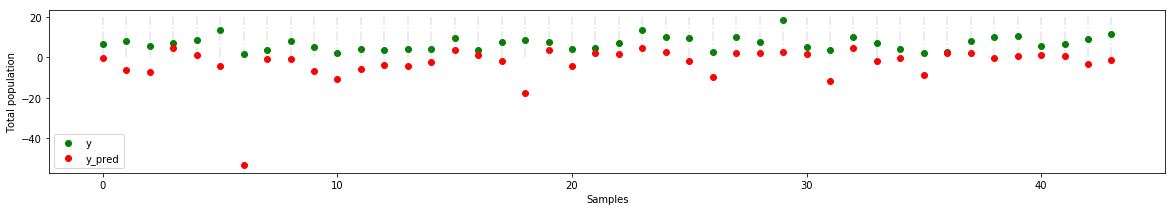

In [22]:
if __name__ == '__main__':
    # Visualització de les dades originals i les prediccions
    plt.figure(figsize=(20, 3))
    plt.scatter(range(Y_pop.shape[0]), Y_pop, color='green', label = 'y')
    plt.scatter(range(Y_pop.shape[0]), y_pop_pred, color='red', label = 'y_pred')
    plt.xlabel('Samples')
    plt.ylabel('Total population')
    plt.legend()

    for x in range(X_pop.shape[0]):
        plt.plot((x, x), (0, 20), '-.', color='gray', alpha=0.2)

    print('Mean error: {:.2f}'.format(np.mean(np.abs(Y_pop - y_pop_pred))))

# Airbnb: dades reals (a baixa escala)

### Airbnb Dataset

Les dades amb les que treballarem en aquesta pràctica són dades reals recopilades per *Airbnb*. 
Aquestes analitzen la informació disponible sobre els llistats d’Airbnb d’una ciutat, proporcionant filtres i mètriques clau perquè pugueu veure com Airbnb s’utilitza per competir amb el mercat d’habitatges residencials.

Amb aquestes dades podrieu fer preguntes fonamentals sobre Airbnb a qualsevol barri o a tota la ciutat. Preguntes com:

- "Quants fitxes hi ha al meu barri i on són?"
- "Quantes cases i apartaments es lloguen amb freqüència a turistes i no a residents a llarg termini?"
- "Quant costen els hostes des del lloguer als turistes (compareu-ho amb els lloguers a llarg termini)?"
- "Quins amfitrions tenen una empresa amb diversos llistats i on?"

Les dades inclou dades com:
- Quantitat de nits que es lloga una vivenda a l'any.
- Estades mínimes.
- Quantes habitacions es lloguen en un edifici.
- Nombre d’ocupats permesos en un lloguer.

En el nostre cas, **volem predir el preu de la vivenda utilitzant el resum donat.**

In [23]:
import zipfile
from os.path import join, dirname

def locate(*path):
    base = globals().get('__file__', '.')
    return join(dirname(base), *path)

def unzip(file):
    zip_ref = zipfile.ZipFile(locate(file), 'r')
    zip_ref.extractall(locate('data'))
    zip_ref.close()

def clean(s):
    try:
        s = s.replace('O', '0').replace(',', '').replace('$', '')
        return np.float(s.split()[0])
    except:
        return np.nan

def tobool(s):
    return s == 't'

if __name__ == '__main__':
    def open_airbnb_data(file):
        unzip(f'{file}.zip')
        
        return pd.read_csv(f'data/{file}.csv',
            converters={
                'zipcode': clean,
                'price': clean,
                'weekly_price': clean,
                'monthly_price': clean,
                'host_is_superhost': tobool,
                'host_identity_verified': tobool,
                'host_has_profile_pic': tobool,
                'is_location_exact': tobool,
                'has_availability': tobool,
                'requires_license': tobool,
                'instant_bookable': tobool,
                'is_business_travel_ready': tobool,
                'require_guest_profile_picture': tobool,
                'require_guest_phone_verification': tobool,
                'summary': lambda s: s or ''
            }
        )
    
    
    df_airbnb = open_airbnb_data('data_public')

In [24]:
if __name__ == '__main__':
    #pd.set_option('display.max_columns', None)
    display(df_airbnb)

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0,18666,https://www.airbnb.com/rooms/18666,20190917034823,2019-09-17,Flat with Sunny Terrace,"Apartment located near the ""Plaza de las Glori...",Nice apartment situated on the penthouse floor...,"Apartment located near the ""Plaza de las Glori...",none,...,False,False,flexible,False,False,31,31,0,0,0.02
1,1,18674,https://www.airbnb.com/rooms/18674,20190917034823,2019-09-17,Huge flat for 8 people close to Sagrada Familia,110m2 apartment to rent in Barcelona. Located ...,Apartment with 110 m2 located in the 6th floor...,110m2 apartment to rent in Barcelona. Located ...,none,...,True,False,strict_14_with_grace_period,False,False,31,31,0,0,0.21
2,2,21605,https://www.airbnb.com/rooms/21605,20190917034823,2019-09-17,Nice and sunny duble room,"The flat is in Poblenou district, and the room...","L'apartament està al barri de Poblenou, i l'ha...","The flat is in Poblenou district, and the room...",none,...,False,False,moderate,False,False,2,0,2,0,3.05
3,3,23197,https://www.airbnb.com/rooms/23197,20190917034823,2019-09-17,FORUM DELUXE 5 MINS WALK CCIB CENTER & SEA!,I do not accept groups of young people under 2...,Elegant spacious apartment suitable for 6. Amp...,I do not accept groups of young people under 2...,none,...,True,False,strict_14_with_grace_period,False,True,2,2,0,0,0.47
4,4,25786,https://www.airbnb.com/rooms/25786,20190917034823,2019-09-17,NICE ROOM AVAILABLE IN THE HEART OF GRACIA,JUST GO THROUGH THE MANY REVIEWS I GOT THROUGH...,Room available for rent.- PEDRO PEREZ. Share...,JUST GO THROUGH THE MANY REVIEWS I GOT THROUGH...,none,...,True,False,strict_14_with_grace_period,True,True,1,0,1,0,2.29
5,5,31377,https://www.airbnb.com/rooms/31377,20190917034823,2019-09-17,"Room for 2, Sagrada Famili",The room in 500 m from Sagrada Familia. 3 bran...,"Great location, right next to Sagrada Familia,...",The room in 500 m from Sagrada Familia. 3 bran...,none,...,False,False,strict_14_with_grace_period,False,False,3,0,3,0,0.08
6,6,31380,https://www.airbnb.com/rooms/31380,20190917034823,2019-09-17,"Room for 2-3. Barcelona, Sagrada Famili","Room for 2-3. Great location, right next to S...","Great location, right next to Sagrada Familia,...","Room for 2-3. Great location, right next to S...",none,...,False,False,strict_14_with_grace_period,False,False,3,0,3,0,0.77
7,7,31958,https://www.airbnb.com/rooms/31958,20190917034823,2019-09-17,"Gaudi Attic 1, Friendly Rentals","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",none,...,True,False,strict_14_with_grace_period,False,False,43,43,0,0,1.71
8,8,32471,https://www.airbnb.com/rooms/32471,20190917034823,2019-09-17,"Gaudi Attic 2, Friendly Rentals","This apartment has: 2 double beds, 1 single be...","This apartment has: 2 double beds, 1 single be...","This apartment has: 2 double beds, 1 single be...",none,...,True,False,strict_14_with_grace_period,False,False,43,43,0,0,0.79
9,9,32615,https://www.airbnb.com/rooms/32615,20190917034823,2019-09-17,"Sunny room, top floor with 2 terraces!","Cozy apartment in a quiet area, with 2 fantast...","Are you looking for a cozy, sunny, relaxed pla...","Cozy apartment in a quiet area, with 2 fantast...",none,...,False,False,moderate,False,False,1,0,1,0,0.17


### Bag-of-words

Per tal de poder treballar amb text haurem de crear un vector que representi allò que hi està escrit.
Aquesta idea s'anomena **bag-of-words** i és una representació simplificadora que s’utilitza en el processament de llenguatges naturals i la recuperació d’informació (IR). 
En aquest model, un text (com una frase o un document) es representa com la bossa (multiset) de les seves paraules, prescindint de la gramàtica i fins i tot de l'ordre de les paraules, però mantenint la multiplicitat. 

Aquest s’utilitza habitualment en mètodes de classificació o regressió de documents on l’ocurrència (freqüència de) de cada paraula s’utilitza com a característica per entrenar un predictor.

**PipeLine:**

```Python
text = 'Apartment located near the "Plaza de las Glorias". Great apartament in Barcelona', ...
```
Un cop tinguem les nostres dades, hem de passar pel procés de neteja. Per als conjunts de dades de text en general, això inclou sovint:
- Eliminació de la puntuació.
- Eliminació de les paraules d'aturada, en anglès *stopword*, (coses com "el", "això", "què").
- Stemming / lematization (reduir les paraules a la seva forma base eliminant sufixos com "-ed", "-ing", plurals...) (MÉS AVANÇAT).

A més, el tracte de text i comentaris en línia requereix una eliminació addicional d’elements com hiperenllaços, noms d’usuari i missatges automatitzats (el comentari més comú en aquest conjunt de dades era un missatge de benvinguda de Wikipedia per als nous usuaris).

```Python
# Tokenització
tok = [['apartment', 'located', 'near', 'the', 'plaza', 'de', 'las', 'glorias', 'great', 'apartament', 'in', 'barcelona'], ... ]

# Paraules Comuns (Suposem 3)
com = ['apartament', 'Barcelona', 'airport']
```

Per convertir les paraules en quelcom que un algorisme d’aprenentatge automàtic pugui comprendre i processar, hem de vectoritzar. En poques paraules, aquest és el procés de convertir les paraules en vectors multidimensionals de tal manera que el significat o el context de la paraula es correlaciona amb aquest vector. En cert sentit, la vectorització permet als ordinadors quantificar el significat de les paraules mapant significats de paraules similars a espais vectorials similars.

```Python
# Vector de característiques
feats = [
    np.array([1, 1, 0]), # els 1 representes que la paraula està a la frase i els 0 que no.
    ...
]
```

In [25]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from tqdm import tqdm_notebook


import nltk
nltk.download('punkt')
nltk.download('stopwords')

def tokenize(df):
    """
    Funció que donat el dataframe amb les dades d'Airbnb retorna
    una llista de llistes on cada subllista conté les paraules
    tokenitzades del text extret de la columna "summary".
    
    Per facilitar la feina de la tokenització podeu utilizar les stopwords 
    que venen amb la llibreria nltk i la funció word_tokenize.
    
    :param df: DataFrame que conté el dataset
    :return : Llista de llistes amb la informació indicada
    """    
    
    def clean(token):
       
        token = token.lower()
        token = token.replace(".","")
        token = token.replace(",","")
        token = token.replace(":","")
        token = token.replace("\"","")
        token = token.replace("!","")
        token = token.replace("â€œ","")
        token = token.replace("â€˜","")
        token = token.replace("*","")
        token = token.replace("``","")
        token = token.replace("(","")
        token = token.replace(")","")
        token = token.replace("{","")
        token = token.replace("}","")
        token = token.replace("0","")
        token = token.replace("1","")
        token = token.replace("2","")
        token = token.replace("3","")
        token = token.replace("4","")
        token = token.replace("5","")
        token = token.replace("6","")
        token = token.replace("7","")
        token = token.replace("8","")
        token = token.replace("9","")
        return token
    
    def stemming_lematization(sentence):
        porter = nltk.stem.PorterStemmer()
        lancaster=nltk.stem.LancasterStemmer()
        lista = []
        a = stopwords.words('english') + stopwords.words('spanish')
        for word in sentence:
            if word not in a: 
                words = porter.stem(word)
                words = lancaster.stem(words)
                lista.append(words)
        return lista
        
        
    
    #tokens = df['summary']  SOLUCION
    #MEJORA NUMERO 2
    tokens = df['summary']+str(df['amenities']) #descripcion de si tiene wifi etc
    tokens = tokens.apply(clean)
    tokens = tokens.apply(nltk.word_tokenize) # mejorar limpieza
    lista = []
    for sentence in tokens:
        lista.append(stemming_lematization(sentence))
    return lista
        
    

[nltk_data] Downloading package punkt to /home/guillem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/guillem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<div style='background: #FCD02C; color: #333; padding: 20px; border-radius: 5px;'>
    <div style='float: right; font-weight: bold;'>1/1</div>
    Perfecte
</div>

In [26]:
from collections import Counter

def most_common(tokens, n):
    """
    Funció que retorna les n parales més frequents a partir dels tokens
    
    :param tokens: Tokens obtinguts amb `tokenize`
    :param n: Int, nombre d'elements que es demanen retornar
    :return: Llista amb el top n elements
    """
    common = []
    for sentence in tokens:
        for word in sentence:
            common.append(word)
    
    freq_set = Counter(common).most_common(n)
    freq = [a for a,b in freq_set]
    
    return freq

<div style='background: #FCD02C; color: #333; padding: 20px; border-radius: 5px;'>
    <div style='float: right; font-weight: bold;'>1/1</div>
    Perfecte
</div>

In [299]:
from tqdm import tqdm_notebook
def normalize_columns(arr):
    arr = arr - arr.mean(axis=0)
    safe_max = np.abs(arr).max(axis=0)
    safe_max[safe_max==0] = 1
    arr = arr / safe_max
    return arr

def get_features(df, tokens, most_common_tokens):
    """
    Funció que retorna un vector de 0 i 1 per cadascuna de les entrades del dataset,
    en funció de si les paraules comunes es troben o no entre els tokens.
    
    Per a cada dada, mirarem si quines de les paraules comunes apareixen entre els tokens,
    posant un 1 a les que sí i un 0 a les que no.
    
    Cada dada tindrà, a més dels 0/1 corresponents a les N paraules més comunes, una columna
    més, corresponent a la columna 'require_guest_phone_verification' de 'df'. Per tant,
    el retorn per cada dada serà
    [0, 1, .........., 0,         1         ]
    |N tokens més comuns, columna addicional|
    
    *Únicament es permeten bucles pel càlcul dels 0/1s dels tokens*
    
    :param df: DataFrame que conté el dataset
    :param tokens: Tokens per cada entrada del dataset
    :param most_common_tokens: N tokens més comuns
    :return : Matriu de característiques de cada entrada del dataset, incloent els
        0/1s dels tokens i la columna 'require_guest_phone_verification'
    """
    a = []
    for index in tqdm_notebook(range(len(tokens))):
        array = []
        for mctok in most_common_tokens:
            if mctok in tokens[index]:
                #array.append(1)
                time = tokens[index].count(mctok)
                array.append(time)
            else:
                array.append(0)
        a.append(array)
    
    #SOLUCION
    phones = np.array(df['require_guest_phone_verification'].astype('Int8')).tolist()
    #accommodates 	bathrooms 	bedrooms 	beds
    #MEJORA NUMERO 3 HEMOS PENSADO QUE A CUANTO MAYOR NUMERO DE HABITACIONES, MAYOR COSTE TIENE LA HABITACION
    #TAMBIEN LO PODEMOS TRASLADAR, A CUANTAS PERSONAS MAXIMAS PUEDEN OCUPAR LA VIVIENDA, Y EL NUMERO DE LAVABOS
    accommodates = np.array(df['accommodates'].astype('Int8')).tolist()
    bedroom = np.array(df['accommodates'].astype('Int8')).tolist()
    bathrooms = np.array(df['bathrooms'].fillna(0).astype(int)).tolist()
    beds = np.array(df['bedrooms'].fillna(0).astype(int)).tolist()
    result = np.hstack((a, np.atleast_2d(phones).T)) 
    result = np.hstack((result, np.atleast_2d(accommodates).T))
    result = np.hstack((result, np.atleast_2d(bedroom).T)) 
    result = np.hstack((result, np.atleast_2d(bathrooms).T))
    result = np.hstack((result, np.atleast_2d(beds).T)) 
    
    #result = normalize_columns(result)
    #result[result<0]=0
    #result = normalize_columns(result)
    return result

<div style='background: #FCD02C; color: #333; padding: 20px; border-radius: 5px;'>
    <div style='float: right; font-weight: bold;'>2/2</div>
    Perfecte
</div>

El resultat serà un *np.array* (no necessàriament amb aquest valors):

```python
np.array([
    np.array([0, 1, 1, 0, ...]), # 1r Summary
    np.array([0, 1, 1, 1, ...]), # 2n Summary
    ...
])
```

### Partició de dades

En l'aprenentatge automàtic, una tasca habitual és l'estudi i la construcció d'algorismes que poden aprendre i fer prediccions sobre dades. Aquests algoritmes funcionen fent prediccions o decisions basades en dades, mitjançant la creació d'un model matemàtic a partir de dades d'entrada.

Les dades que s’utilitzen per construir el model final normalment provenen de múltiples conjunts de dades. En particular, dos conjunts de dades s’utilitzen habitualment en diferents etapes de la creació del model: dades d'entrenament (train) i de prova (test).

El model s’adapta inicialment a un conjunt de dades d’entrenament, que és un conjunt d’exemples que s’utilitzen per ajustar els paràmetres (per exemple, pesos del model de regressió linal) del model. 
El model es forma en el **conjunt de dades d’entrenament** que sovint consisteix en parells d’un vector d’entrada (o escalar) i el vector de sortida corresponent (o escalar), que es denomina habitualment com a objectiu (o etiqueta). El model actual s'executa amb el conjunt de dades d'entrenament i produeix un resultat, que es compara després amb l'objectiu, per a cada vector d'entrada del conjunt de dades d'entrenament. A partir del resultat de la comparació i de l'algorisme d'aprenentatge específic que s'utilitza, s'ajusten els paràmetres del model. L'adaptació del model pot incloure selecció de variables i estimació de paràmetres.

El **conjunt de dades de prova** és un conjunt de dades utilitzat per proporcionar una avaluació imparcial d’un model. Si les dades de prova no s’han utilitzat mai durant l'entrenament, el resultats representa el comportament esperat del model.

A continuació heu d'implementar la funció *split* que crea aquesta partició de dades.

In [27]:
from random import shuffle

def split(X, Y, train_percent, random_seed=None):
    """
    Divideix el conjunt de dades en dos subconjunts aleatoris diferents, sense
    intersecció.
    La divisió es fa conjuntament en X i Y, és a dir, donat una dada x de X,
    la seva corresponent y en Y es troba en el mateix conjunt
    X = [[1, 2, 3], [2, 3, 1], ..., [1, 4, 5]]
    Y = [1, 2, ..., 5]
    
    Train: X = [[1, 2, 3], [1, 4, 5]]; Y = [1, 5]
    Test:  X = [[2, 3, 1]]; Y = [2]
    
    :param X: Dades del model
    :param Y: Corresponents valors a predir
    :param train_percent: Percentatge entre 0 i 1, indicant el nombre
        d'elements que contindrà el conjunt de train
    :param random_seed: En cas de que sigui necessari (no és obligatori fer-ho servir), 
        per fixar el comporament de random
    :return: Una llista/tupla que contingui, en aquest ordre, 
        * Conjunt train X [NDadesTrain, NFeatures]
        * Conjunt test X [NDadesTest, NFeatures]
        * Conjunt train Y [NDadesTrain]
        * Conjunt test Y [NDadesTest]
    """
    num = int(train_percent*len(X))
    messyIndex = [i for i in range(len(Y))]
    shuffle(messyIndex)
    
    trainX = X[messyIndex[:num]]
    #trainX = np.insert(trainX, 102, len(trainX[0]), axis=1)

    testX = X[messyIndex[num:]]
    #testX = np.insert(testX, 102, len(trainX[0]), axis=1)
    
    trainY = Y[messyIndex[:num]]
    testY = Y[messyIndex[num:]]
    #print(len(trainX[0]))

    return (trainX, testX, trainY, testY)

<div style='background: #FCD02C; color: #333; padding: 20px; border-radius: 5px;'>
    <div style='float: right; font-weight: bold;'>2/2</div>
    Perfecte
</div>

Abans de generar els conjunts d'entrenament i prova cal generar els vectors que representen cada entrada de les dades.

In [301]:
import sys
if __name__ == '__main__':


    tok = tokenize(df_airbnb)
    #MEJORA 10
    com = most_common(tok, 500) #PREDETERMINADO 100
    #print(com)
    
    feats = get_features(df_airbnb, tok, com)
    np.set_printoptions(threshold=sys.maxsize)
    #print(feats[:,:10])


In [316]:
if __name__ == '__main__':
    # Valors amb els que predirem el preu de la vivenda
    
    X = add_bias(feats)
    #MEJORA 6
    Y = df_airbnb['price']
    outliers= df_airbnb[(df_airbnb['price']>250)|(df_airbnb['price']<25)]
    X = np.delete(X, outliers.index, axis=0)
    # Valors reals de la vivenda
    #Y = df_airbnb['price'].values
  
    Y = Y.drop(outliers.index)
    Y = Y.values
    
    


    
    # Partim en train i test
    X_train, X_test, Y_train, Y_test = split(X, Y, train_percent=0.80)

In [317]:
if __name__ == '__main__':
    # Parametres per defecte del model
    w0 = np.random.normal(size=(1, X.shape[1]))

    # Optimització del model sobre train
    wf = gradient_descend(lambda w: model(w, X_train, Y_train), w0, 0.01, max_iter=5000, print_iters=100) # ~ @2min

    # Realitzem la predicció sobre test
    
    #MEJORA NUMERO 1
    y_pred = linear_regression(X_test, wf)
    y_pred[y_pred < 0] = np.mean(y_pred)

100.00/47.35
200.00/40.01
300.00/39.36
400.00/39.10
500.00/38.90
600.00/38.73
700.00/38.59
800.00/38.48
900.00/38.39
1.00K/38.31
1.10K/38.24
1.20K/38.18
1.30K/38.13
1.40K/38.09
1.50K/38.05
1.60K/38.02
1.70K/37.98
1.80K/37.95
1.90K/37.93
2.00K/37.90
2.10K/37.88
2.20K/37.85
2.30K/37.83
2.40K/37.81
2.50K/37.79
2.60K/37.77
2.70K/37.75
2.80K/37.73
2.90K/37.71
3.00K/37.69
3.10K/37.68
3.20K/37.66
3.30K/37.64
3.40K/37.62
3.50K/37.61
3.60K/37.59
3.70K/37.58
3.80K/37.56
3.90K/37.54
4.00K/37.53
4.10K/37.51
4.20K/37.50
4.30K/37.48
4.40K/37.47
4.50K/37.46
4.60K/37.44
4.70K/37.43
4.80K/37.42
4.90K/37.40
5.00K/37.39


Mean error: 27.30


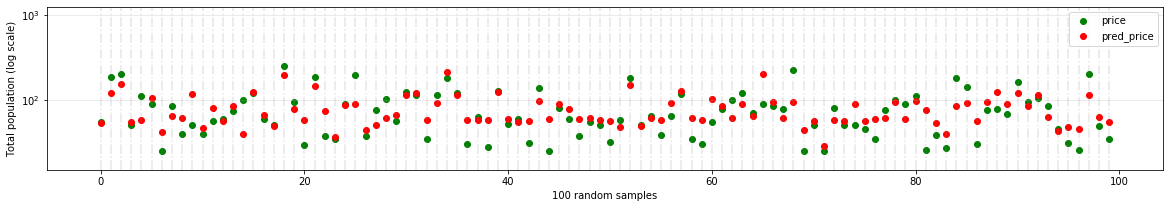

In [318]:
if __name__ == '__main__':
    # Mostrem únicament 100 dades en el gràfic
    size = 100
    sample = np.random.choice(X_test.shape[0], size=size, replace=False)

    # Mínima i màxima Y a mostrar en el gràfic
    miny = np.minimum(y_pred[sample].min(), Y_test[sample].min()) - 10
    maxy = np.maximum(y_pred[sample].max(), Y_test[sample].max()) + 1e3

    # Visualització de les dades originals i les prediccions
    plt.figure(figsize=(20, 3))
    plt.scatter(range(size), Y_test[sample], color='green', label = 'price')
    plt.scatter(range(size), y_pred[sample], color='red', label = 'pred_price')
    plt.xlabel('100 random samples')
    plt.ylabel('Total population (log scale)')
    plt.yscale('symlog')
    plt.ylim([miny, maxy])
    plt.grid(axis='y', which='minor', alpha=0.2)
    plt.grid(axis='y', which='major', alpha=0.3)
    plt.legend()

    for x in range(size):
        plt.plot((x, x), (miny, maxy), '-.', color='gray', alpha=0.2)

    print('Mean error: {:.2f}'.format(np.mean(np.abs(Y_test - y_pred))))

# Millores i Kaggle

### ** Dels següents punts és obligatori implementar-ne dos per la pràctica, fes-ho en noves cel·les al final del notebook, no modifiquis les anteriors.**
#### **Per Kaggle pots duplicar el notebook i implementar tants punts com vulguis.**

Cap de les implementacions que facis pot modificar la regressió lineal en sí mateixa (la funció `linear_regression`) de forma que:

* Tingui més paràmetres que la $w$ ja existent
* Afegeixi més complexitat al model

Dit això, es proposa:

1. Donat el tipus de dades, té sentit que la regressió lineal dongui nombres negatius? Compta si decideixes controlar-ho a nivell de la fòrmula de la regressió (vs a nivell dels valors predits), potser el model tendirà a modelar els outliers (valors fora del normal/mitja/distribució) enlloc dels elements representatius.

* Tokenitza i busca tokens més comuns no solament a `summary`, sinó també a les altres columnes que contenen text.

* Afegeix més features al vector X. El model s'entrena amb les característiques extretes de la columna `summary` i `require_guest_phone_verification`, però perque no fer-ne servir més?
> Tingues en compte que no pots agafar cap de les columnes de preu (`price`, `weekly_price`, `monthly_price`, `security_deposit`, `cleaning_fee` i `extra_people`), ja que en les dades de Kaggle no està disponible

* Segons quines dades agafis, és possible que els valors de la característiquis siguin molt dispars. Per exemple, una columna pot tenir de màxim 1 però una altra podria tenir 1000. Normalitza aquests valors de forma que tots tinguin el mateix màxim i mínim. Pots normalitzar també el vector a predir Y, sempre i quan ho tinguis en compte en les noves prediccions.

* La regressió lineal, com el nom indica, és un model lineal, i per tant està limitat amb el tipus de dades que pot representar. Per exemple, generalment, no pot modelar adequadament dades exponencials, logarístimiques, quadràtiques, etc. Això, però, es pot mitigar mitjançant les característiques que es passen al model. Per exemple, si l'entrada és $x$, podríem ampliar aquesta entrada a $(x, x^2)$, on la segona part és simplement cada una de les característiques al quadrat. D'igual forma, podríem ampliar indefinidament $(x, x^2, log(x), e^x, ...)$, però evidentment el cost computacional i el temps d'entrenament creixen, i la millora cada cop és més marginal, si n'hi ha.

* Filtra les dades per evitar utilitzar outliers, de forma que no afectin en l'entrenament.

* Fes una millor selecció de tokens, ens interessen totes les paraules? Tot i que no siguin stopwords, volem tots els números, símbols, etc.?

* Per regressió es poden triar múltiples funcions d'error. Aquí estem fent simplement la distància euclidea, però es pot estudiar l'ús d'altres com: Mean Squared Error, Mean Absolute Error, Huber Loss, d'entre altres. Algunes d'elles són més robustes contra outliers, d'altres més sensibles.

* Els paràmetres inicials es trien random segons una distribució normal $N(0, 1)$, són adequats donats els valors de les característiques i de l'output que esperem? Normalitzar tant $X$ com $Y$ pot ajudar a que ho siguin, en cas que no ho facis, aquests valors poden allargar/dificultar el procés.

* Selecciona un nombre diferent de tokens més comuns. Inicialment utilitzem 100, són masses/pocs? Compte amb el cost computacional.

* Hem utilitzat la forma binomial de bag of words, és a dir 0 o 1, però es podria mirar si implementar la multinomial (0-n, on n és el nombre d'aparicions), ajuda en l'entrenament.

* Bag of words és una forma bastant naive de tractar el text. Una millora, que no implica grans canvis en el codi, és implementar TF-IDF.

* A part d'intentar trobar una alpha òptima (en el sentit de temps inverit vs distància moguda), pots implementar una que aquest pas decaigui amb el temps. Per exemple, pots implementar una caiguda exponencial. Sigui $\alpha_0$ el pas inicial, $it$ la iteració actual, $0 < \beta < 1$ la caiguda que realitza i $\gamma > 0$ el nombre d'iteracions cada quan s'aplica
$$\alpha = \alpha_0 \cdot \beta ^ {\frac{it}{\gamma}}$$
El plot mostra el comportament al llarg de les iteracions. Aplicant una divisó entera enlloc de flotant, es pot aconseguir un efecte "escala" enlloc de continu.

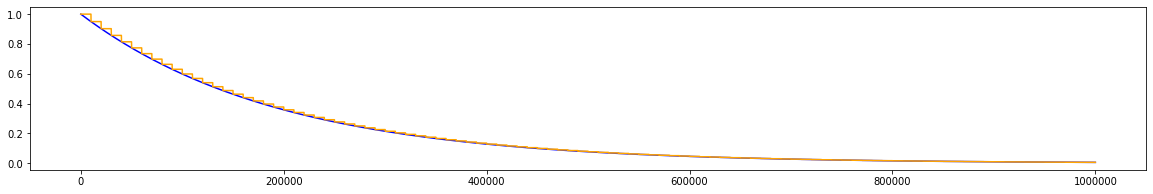

In [308]:
if __name__ == '__main__':
    alpha_0 = 1
    beta = 0.95
    gamma = 10000

    iters = np.arange(1e6)
    plt.figure(figsize=(20, 3))
    plt.plot(iters, alpha_0 * beta ** (iters / gamma), color='b')
    plt.plot(iters, alpha_0 * beta ** (iters // gamma), color='orange')

### Codi per Kaggle

Suposant que has trobat un model adequat a partir del teu split train/test, ara s'entrena un model igual (modifica el codi apropiadament) amb totes les dades.

Amb aquest model final, es prediu sobre el conjunt de dades de Kaggle i es guarda el resultat. Tingueu en compte que el resultat que us mostrarà Kaggle és **sobre un 30% de les totes les dades que envieu**. Si baseu tot el model en els nombres que us digui Kaggle, estareu cometent un greu error, doncs no generalitzarà al 70% restant. Per trobar el millor model i provar les diferents millores, utilitzeu el vostre split train/test.

https://www.kaggle.com/t/e5f6d1562dea41e68a53af9627646552

In [309]:
if __name__ == '__main__':
    # Obtenim les features de les dades de Kaggle
    df_kaggle = open_airbnb_data('data_kaggle')
    
    # Tokenitzem, agafant els més comuns que hem trobat abans
    tok_kaggle = tokenize(df_kaggle)
    feats_kaggle = get_features(df_kaggle, tok_kaggle, com)
    
    # Valors amb els que predirem el preu de la vivenda
    X_kaggle = add_bias(feats_kaggle)

In [310]:
if __name__ == '__main__':    
    # Entrenem el model, però ara amb totes les dades
    # Modifica, si cal, per tal d'utilitzar les millores que hagis implementat
    w0 = np.random.normal(size=(1, X.shape[1]))
    wf_kaggle = gradient_descend(lambda w: model(w, X, Y), w0, 0.01, max_iter=5000, print_iters=100)    

    # Efectuem la predicció i guardem el resultat
    y_pred_test = linear_regression(X_kaggle, wf_kaggle)
    #MEJORA NUMERO 1
    y_pred_test[y_pred_test < 0] = np.mean(y_pred_test)
    
    df_kaggle['pred_price'] = y_pred_test
    df_kaggle[['id', 'pred_price']].to_csv('submission.csv', index=None)

100.00/48.30
200.00/35.64
300.00/34.97
400.00/34.84
500.00/34.74
600.00/34.66
700.00/34.60
800.00/34.54
900.00/34.49
1.00K/34.45
1.10K/34.41
1.20K/34.38
1.30K/34.35
1.40K/34.32
1.50K/34.29
1.60K/34.27
1.70K/34.25
1.80K/34.22
1.90K/34.20
2.00K/34.18
2.10K/34.17
2.20K/34.15
2.30K/34.13
2.40K/34.11
2.50K/34.10
2.60K/34.08
2.70K/34.06
2.80K/34.05
2.90K/34.03
3.00K/34.02
3.10K/34.00
3.20K/33.99
3.30K/33.98
3.40K/33.96
3.50K/33.95
3.60K/33.94
3.70K/33.92
3.80K/33.91
3.90K/33.90
4.00K/33.88
4.10K/33.87
4.20K/33.86
4.30K/33.85
4.40K/33.84
4.50K/33.83
4.60K/33.81
4.70K/33.80
4.80K/33.79
4.90K/33.78
5.00K/33.77


### Implementa a continuació dos dels punts anteriors

Copia, si fes falta, les funcions que necessitis i canvia'ls-hi el nom

In [ ]:
"""
ALGUNES MILLORES ESTAN POSADES COM :
#MEJORA NUMERO 1
#MEJORA NUMERO 2
Altres hem creat una funcio, ja que creiem que per nosaltres era millor posar-ho en el codi
La solució del exercici esta possat com SOLUCIO COMENTAT
"""
"""
MEJORAS:
1
2
3
4?
6
7
8
10
11?
"""

<div style='background: #FCD02C; color: #333; padding: 20px; border-radius: 5px;'>
    <div style='float: right; font-weight: bold;'>2/2</div>
    Perfecte
</div>